In [34]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [35]:
df_a_raw = pd.read_csv("preprocessed_data_with_cate.csv", sep = ',', engine='python', encoding='unicode_escape')

## Drop collinear/unary/unnecessary predictors

In [36]:
# Drop unnecessary predictors
#df_a_raw.drop(['Facebook.Id', 'Page.Admin.Top.Country', 'Video.Length', 'Post.Created'], inplace = True, axis = 1)
#df_a_raw.columns

### (LIWC) Selective dropping from dataset

In [37]:
# Drop meaningless indicators

# Punctuation
df_a = df_a_raw.drop(['AllPunc', 'SemiC', 'Comma', 'Colon', 'Period', 'Parenth', 'OtherP','Quote',
                      'Apostro','Exclam','Dash','QMark'], axis = 1)

# Informal language
df_a.drop(['informal','filler','netspeak', 'assent','nonflu','swear'], inplace = True, axis = 1)

# Relativity - Meaningless if using bag of words analysis (likely case)
df_a.drop(['motion','space','time','relativ'], inplace = True, axis = 1)

# Time orientations - Drop all
df_a.drop(['focuspast','focuspresent','focusfuture'], inplace = True, axis = 1)

# Biological - Drop all
df_a.drop(['body','ingest','sexual','bio'], inplace = True, axis = 1)

# Perceptual - Keep them for now

# Cognitive processes - Keep only overall category
df_a.drop(['discrep','tentat','certain','cause','insight','differ'], inplace = True, axis = 1)

# Social Processes - Girl/Boy might be of some use? Keep for now
df_a.drop(['friend'], inplace = True, axis = 1)

# Affective processes - Drop all (sentiment analysis done separately)
df_a.drop(['affect','anx', 'posemo','negemo'], inplace = True, axis = 1)

# Other grammer - Comparisons might be interesting
df_a.drop(['number','quant','interrog', 'compare', 'adj', 'verb'], inplace = True, axis = 1)

# Linguistic dimensions - Comparisons might be interesting
df_a.drop(['negate','conj','adverb', 'auxverb', 'prep', 'article','ipron','they','shehe','you',
           'we','i','ppron','pronoun','fnctn'], inplace = True, axis = 1)

## LIWC-only Analysis - Drop all other vars except target
- Keeping category as useful separator. Could also group by it later on 
- Same goes for Type

### Other interesting vars worth exploring later
- Post.Views is interesting for further analysis
- WC from LIWC could also be used as a sort of grouping and categorization method

### Other notes:
- Total.Views : The combined views for a native Facebook video of both the views from the parent post, and the shares of that parent post

In [32]:
# Drop all other vars except target
df_liwc = df_a.drop(['User.Name', 'Likes.at.Posting', 'Followers.at.Posting',
                     'Likes', 'Comments', 'Shares', 'Love', 'Wow','Haha', 'Sad', 'Angry', 'Care', 'Video.Share.Status',
                     'Is.Video.Owner.', 'Post.Views', 'Total.Views', 'Total.Views.For.All.Crossposts', 'Sponsor.Name', 
                     'Sponsor.Category','Message_sentiment', 'Message_subjective', 'Link', 
                     'is_linked', 'image_text_ind', 'sponsor_cate_effect','page_cate_effect',
                     'page_desc_sentiment', 'page_desc_subjective', 'Link', 'Live Video','Live Video Complete',
                     'Live Video Scheduled', 'Native Video', 'Photo','Status', 'Video', 'YouTube', 'crosspost', 'owned', 
                     'share', '-', 'No','Yes',
                     #'Message_len','page_desc_len','link_title_len', 'link_desp_len',
                     'PageSinceCreated', 'PageCreatedYear', 'PageCreatedMonth', 'PageCreatedDay',
                     'PageCreatedHour', 'PostCreatedYear','PostCreatedMonth', 'PostCreatedday', 'PostCreatedHour'], axis = 1)


# Summary vars
df_liwc.drop(['WC','WPS','Dic','Sixltr', 'Clout', 'Authentic','Tone'], inplace = True, axis = 1)

In [33]:
# Drop attributes for grouping (can be used in future iterations)
df_ready = df_liwc.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

df_ready.columns

Index(['Type', 'Total.Interactions', 'Analytic', 'anger', 'sad', 'social',
       'family', 'female', 'male', 'cogproc', 'percept', 'see', 'hear', 'feel',
       'health', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'Message_len',
       'Message_sentiment_category', 'Message_subjective_category',
       'link_title_len', 'link_desp_len', 'page_desc_len',
       'page_desc_sentiment_category', 'page_desc_subjective_category'],
      dtype='object')

### Generate correlation matrix, profiling report and split train/test

In [16]:
'''df_corr = df_ready.corr(method='pearson')#.drop(['Page.Category', 'Type'],axis = 1)
df_corr.to_csv("first_pass_corrmat.csv")'''

'df_corr = df_ready.corr(method=\'pearson\')#.drop([\'Page.Category\', \'Type\'],axis = 1)\ndf_corr.to_csv("first_pass_corrmat.csv")'

In [17]:
# Dummify
X = pd.get_dummies(df_ready, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)
#X = df_ready.copy()
y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

In [18]:
'''profile = ProfileReport(df_ready, title="Pandas Profiling Report")
profile.to_file("baseline.html")'''

'profile = ProfileReport(df_ready, title="Pandas Profiling Report")\nprofile.to_file("baseline.html")'

In [19]:
from sklearn.model_selection import train_test_split

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

### Define Models

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def forest(X, labels):
    forest = RandomForestRegressor(random_state=13, n_estimators=500, bootstrap=True, oob_score=True, max_features='sqrt')

    return forest.fit(X, labels)

def lightforest(X, labels):
    lightforest = RandomForestRegressor(random_state=13, n_estimators=100, bootstrap=True, oob_score=True, 
                                    max_depth=7, max_features='sqrt')
    return lightforest.fit(X, labels)

# https://xgboost.readthedocs.io/en/stable/python/python_api.html
def XGB(X,labels):
    xgb = XGBRegressor(random_state=13, n_estimators = 600)
    
    return xgb.fit(X, labels)

# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
def LGBM(X,labels):
    model = LGBMRegressor(random_state=13, n_estimators = 500)
    return model.fit(X, labels)

# feature importance
#print(model.feature_importances_)

#print('\nAccuracy of random forest with 10-fold CV, 4 repeats: %.3f (STD: %.3f)' % (np.mean(scores_rf), np.std(scores_rf)))

C:\Users\tanzc\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## First Pass - Baseline

In [64]:
import time
start = time.time()

# Takes some time to run

#rf_model = forest(x_train,y_train)
lrf_model = lightforest(x_train,y_train)
#xgb_model = XGB(x_train,y_train)
#lgbm_model = LGBM(x_train,y_train)

stop = time.time()
print(f"Training time: {stop - start} seconds")


Training time: 10.141616821289062 seconds


In [65]:
# Make predictions and print metrics
#predictions = lrf_model.predict(x_test)
#predictions = lgbm_model.predict(x_test)
predictions = lrf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', lrf_model.score(x_test, y_test))

Mean Absolute Error: 639.8543896893221
Root Mean Squared Error: 9611.143895879157
R^2:  -0.009001131814376562


In [66]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
df_ready['Total.Interactions'].describe()

count    212787.0000000
mean        456.3213495
std        8444.9175969
min           0.0000000
25%          11.0000000
50%          47.0000000
75%         201.0000000
max     1811547.0000000
Name: Total.Interactions, dtype: float64

In [67]:
coeff_list = pd.DataFrame(list(zip(X.columns, lrf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
#coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(10)

,predictor,feature importance
16,power,0.0858842
13,drives,0.0796137
8,percept,0.0790883
10,hear,0.0711555
3,social,0.0704321
0,Analytic,0.0644156
12,health,0.0489723
5,female,0.0472032
9,see,0.0438126
6,male,0.0402065


In [68]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = None
coeff_list['predictor']

16                                       power
13                                      drives
8                                      percept
10                                        hear
3                                       social
0                                     Analytic
12                                      health
5                                       female
9                                          see
6                                         male
15                                     achieve
7                                      cogproc
2                                          sad
20                                     leisure
4                                       family
18                                        risk
24                                       death
14                                 affiliation
26      Message_subjective_category_Subjective
19                                        work
27       page_desc_sentiment_category_Positive
21           

### Important features (Not relevant anymore)
- focuspresent : present tense words (likely not useful)
- Analytic : further research into paper required
- percept : Related to 5 senses - Probably posts that involve the sensory experiences over abstract ones (e.g. philosophy)
- WPS : Number of words per sentence - Perhaps writing longer/shorting 
- focusfuture : future tense words (likely not useful)
- power : Posts that use a lot of strong/impactful words or words that stir emotion: 'superior', 'bully', 
- social : Posts that involve interaction between people
- drives : Overarching category for 'power'. Not useful. Drop in next iteration.
- WC: Number of words in the article. Self-explanatory. Probably further analysis or grouping required.
- see : Words that involve vision sight. Potentially related to news articles where people report on seeing/observing events?
- male : Self-explanatory. Not sure how useful.
- posemo : Positive emotion/sentiment
- bio : Biological processes (eating/pain/vomit/bleed). Probably not useful
- affect : Psychological words that describe emotional state. Unable to infer direction, not useful. Posemo and negemo should be enough

# Testing for various brands/types/categories

In [81]:
df_a_raw['Page.Name'].value_counts()

Business Insider                 8674
News 4 San Antonio               6948
Fox Carolina News                6099
Tech Insider                     5482
KENS 5 & Kens5.com               4927
                                 ... 
St. George News | STGnews.com       1
CBS DFW                             1
NowThis Earth                       1
The Urban Dads                      1
WPXI-TV Pittsburgh                  1
Name: Page.Name, Length: 256, dtype: int64

## Business Insider

In [13]:
# Filter to specific brand/category
df_ready = df_liwc[ (df_liwc['Page.Name'] == "Business Insider") ]

# Drop attributes for grouping (can be used in future iterations)
df_ready = df_ready.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

len(df_ready)

8674

In [14]:
# Dummify and split train/test
X = pd.get_dummies(df_ready, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)
#X = df_ready.copy()
y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

In [15]:
import time
start = time.time()

rf_model = forest(x_train,y_train)
#lrf_model = lightforest(x_train,y_train)
#xgb_model = XGB(x_train,y_train)
#lgbm_model = LGBM(x_train,y_train)

stop = time.time()
print(f"Training time: {stop - start} seconds")


Training time: 6.908242702484131 seconds


In [16]:
# Make predictions and print metrics
predictions = rf_model.predict(x_test)
#predictions = lrf_model.predict(x_test)
#predictions = lgbm_model.predict(x_test)
#predictions = lrf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

Mean Absolute Error: 835.2934316295606
Root Mean Squared Error: 6244.429384851751
R^2:  -0.0044838566285272385


In [17]:
coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
#coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(10)

,predictor,feature importance
7,cogproc,0.162333
21,home,0.127767
0,Analytic,0.123427
3,social,0.082994
16,power,0.081168
20,leisure,0.080321
19,work,0.078784
13,drives,0.070614
22,money,0.047792
8,percept,0.028334


## Fox Carolina News

In [18]:
# Filter to specific brand/category
df_ready = df_liwc[ (df_liwc['Page.Name'] == "Fox Carolina News") ]

# Drop attributes for grouping (can be used in future iterations)
df_ready = df_ready.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_ready, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")


# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 4.764584541320801 seconds
Mean Absolute Error: 740.935103698676
Root Mean Squared Error: 4750.556171731624
R^2:  -46.71208997404448


,predictor,feature importance
8,percept,0.119805
9,see,0.117670
6,male,0.105753
0,Analytic,0.090999
3,social,0.073085
20,leisure,0.069693
12,health,0.064285
13,drives,0.058862
10,hear,0.048283
16,power,0.047493


## Tech Insider

In [19]:
# Filter to specific brand/category
df_ready = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") ]

# Drop attributes for grouping (can be used in future iterations)
df_ready = df_ready.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_ready, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")


# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 5.1148810386657715 seconds
Mean Absolute Error: 2183.7584893149033
Root Mean Squared Error: 12694.697722368426
R^2:  0.008859415817663918


,predictor,feature importance
3,social,0.188790
0,Analytic,0.148051
13,drives,0.088510
7,cogproc,0.088260
8,percept,0.079962
20,leisure,0.064688
14,affiliation,0.058956
16,power,0.038942
26,Message_subjective_category_Subjective,0.026278
19,work,0.025630


## Try using percentiles to transform values
## Tech Insider

50th percentile of target (less top 30% of values): 46.0


<AxesSubplot:>

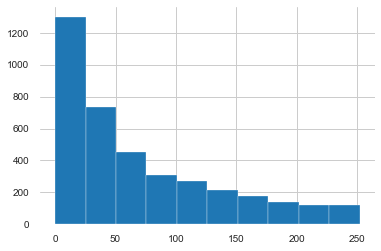

In [30]:
subst = df_liwc.loc[df_liwc['Page.Name'] == "Tech Insider", "Total.Interactions"]

n = 70
midpoint = np.percentile(subst[ (subst < np.percentile(subst, n)) ], 50)

print(f"50th percentile of target (less top {100-n}% of values): {midpoint}")
subst[ (subst < np.percentile(subst, n)) ].hist()

In [21]:
# Filter to specific brand/category
#df_ready = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") | (df_liwc['Page.Name'] == "Tech Insider") ]
df_high = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Total.Interactions'] >= 59) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")


# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 3.1328353881835938 seconds
Mean Absolute Error: 3280.1103653846158
Root Mean Squared Error: 13099.037407351587
R^2:  -0.09267009219958089


,predictor,feature importance
3,social,0.224234
0,Analytic,0.113777
13,drives,0.085392
7,cogproc,0.080142
14,affiliation,0.072496
8,percept,0.058687
6,male,0.058483
21,home,0.046782
20,leisure,0.042258
12,health,0.037798


## Fox Carolina News

50th percentile of target (less top 30% of values): 27.0


<AxesSubplot:>

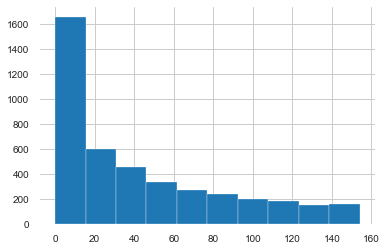

In [22]:
subst = df_liwc.loc[df_liwc['Page.Name'] == "Fox Carolina News", "Total.Interactions"]

n = 70
midpoint = np.percentile(subst[ (subst < np.percentile(subst, n)) ], 50)

print(f"50th percentile of target (less top {100-n}% of values): {midpoint}")
subst[ (subst < np.percentile(subst, n)) ].hist()

In [23]:
# Filter to specific brand/category
#df_ready = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") | (df_liwc['Page.Name'] == "Tech Insider") ]
df_high = df_liwc[ (df_liwc['Page.Name'] == "Fox Carolina News") & (df_liwc['Total.Interactions'] >= 27) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")

# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 4.4693214893341064 seconds
Mean Absolute Error: 1005.2350904469607
Root Mean Squared Error: 6122.873555772265
R^2:  -49.880593874121345


,predictor,feature importance
8,percept,0.115684
9,see,0.107700
0,Analytic,0.097614
6,male,0.084923
20,leisure,0.072772
10,hear,0.069533
3,social,0.067377
12,health,0.062965
13,drives,0.055048
16,power,0.050498


## Fox Carolina News - Links only

50th percentile of target (less top 30% of values): 26.0


<AxesSubplot:>

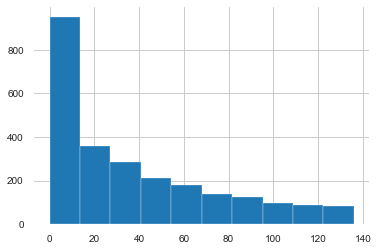

In [24]:
subst = df_liwc.loc[ (df_liwc['Page.Name'] == "Fox Carolina News") & (df_liwc['Type'] == "Link"), "Total.Interactions"]

n = 70
midpoint = np.percentile(subst[ (subst < np.percentile(subst, n)) ], 50)
halfway = subst[ (subst < np.percentile(subst, n)) ].max() / 2

print(f"50th percentile of target (less top {100-n}% of values): {midpoint}")#\n" \
#      f"50% of target (less top {100-n}% of values): {halfway}")
subst[ (subst < np.percentile(subst, n)) ].hist()

In [25]:
# Filter to specific brand/category
#df_ready = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") | (df_liwc['Page.Name'] == "Tech Insider") ]
df_high = df_liwc[ (df_liwc['Page.Name'] == "Fox Carolina News") & (df_liwc['Type'] == "Link") 
                  & (df_liwc['Total.Interactions'] >= 26) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")

# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 2.523379325866699 seconds
Mean Absolute Error: 383.0109931036812
Root Mean Squared Error: 780.2791770563675
R^2:  -0.0043408791360139976


,predictor,feature importance
19,work,0.075718
3,social,0.070369
24,death,0.062796
13,drives,0.059705
0,Analytic,0.058337
7,cogproc,0.055747
16,power,0.052387
14,affiliation,0.051853
20,leisure,0.047797
21,home,0.046960


## Fox Carolina News - Videos only

50th percentile of target (less top 10% of values): 114.0


<AxesSubplot:>

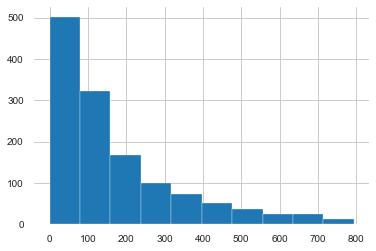

In [26]:
subst = df_liwc.loc[ (df_liwc['Page.Name'] == "Fox Carolina News") & ( (df_liwc['Type'] == "Native Video") | 
                                                             (df_liwc['Type'] == "Video") | 
                                                             (df_liwc['Type'] == "Live Video Scheduled") |
                                                             (df_liwc['Type'] == "Live Video Complete")), "Total.Interactions"]

n = 90
midpoint = np.percentile(subst[ (subst < np.percentile(subst, n)) ], 50)

print(f"50th percentile of target (less top {100-n}% of values): {midpoint}")
subst[ (subst < np.percentile(subst, n)) ].hist()

In [27]:
# Filter to specific brand/category
#df_ready = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") | (df_liwc['Page.Name'] == "Tech Insider") ]
df_high = df_liwc[ (df_liwc['Page.Name'] == "Fox Carolina News") & ( (df_liwc['Type'] == "Native Video") | 
                                                             (df_liwc['Type'] == "Video") | 
                                                             (df_liwc['Type'] == "Live Video Scheduled") |
                                                             (df_liwc['Type'] == "Live Video Complete")) 
                  & (df_liwc['Total.Interactions'] >= 114) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category','Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Total.Interactions']

X.drop(['Total.Interactions'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

start = time.time()
rf_model = forest(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")

# Make predictions and print metrics
predictions = rf_model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', rf_model.score(x_test, y_test))

coeff_list = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
coeff_list.head(15)

Training time: 1.0155785083770752 seconds
Mean Absolute Error: 3328.4349710652637
Root Mean Squared Error: 10660.048241518083
R^2:  -115.69988173028271


,predictor,feature importance
6,male,0.135690
8,percept,0.126363
0,Analytic,0.105805
9,see,0.100915
10,hear,0.074424
20,leisure,0.073293
3,social,0.065926
16,power,0.060311
13,drives,0.060131
12,health,0.051144


## Using score variable - Low and High
### Focus on Tech Insider 

In [38]:
### Get a list of unique pages
pages = df_a['Page.Name'].unique()

### Compute the benchmark for each page
benchmarks=[]

# for each page
for i in pages:
    # get total interactions of last 100 posts
    df_a_page = df_a.loc[df_a['Page.Name'] == i]
    benchmark_df = pd.DataFrame(df_a_page['Total.Interactions']).head(min((len(df_a_page)),100))
    # calculate benchmark - drop top & bottom 25% and take the mean
    upper = np.percentile(benchmark_df['Total.Interactions'],75)
    lower = np.percentile(benchmark_df['Total.Interactions'],25)
    benchmark_df = benchmark_df[(benchmark_df['Total.Interactions'] <= upper) &
                                (benchmark_df['Total.Interactions'] >= lower)]
    benchmarks.append(benchmark_df['Total.Interactions'].mean())

# zip pages & benchmarks into dictionary
page_benchmark = dict(zip(pages,benchmarks))

### compute score for each post
scores = []

# for each post
for j in range(len(df_a)):
    score = 0
    threshold = 5+2 # for facebook
    intr_exceed_threshold = False
    intr_exceed_benchmark = False
    
    # evaluate the conditions with threshold & benchmark
    intr_exceed_threshold = ((df_a.iloc[j,7]>=5) and #'Likes'
        ((df_a.iloc[j,8]+df_a.iloc[j,9]+df_a.iloc[j,10]+df_a.iloc[j,11]+ #'Comments','Shares','Loves','Wow
          df_a.iloc[j,12]+df_a.iloc[j,13]+df_a.iloc[j,14]+df_a.iloc[j,15])>=2) and #'Haha','Sad','Angry','Care'
        (df_a.iloc[j,18]>=2)) #'Post.Views'
    intr_exceed_benchmark = (df_a.iloc[j,6] >= page_benchmark.get(df_a.iloc[j,0])) #'Total.Interactions' >= benchmark with 'Page.Name'
    
    # calculate the score
    if (df_a.iloc[j,6] == 0): #'Total.Interactions'
        score = -2 * page_benchmark.get(df_a.iloc[j,0]) #benchmark with 'Page.Name'
    elif (intr_exceed_threshold and intr_exceed_benchmark):
        score = df_a.iloc[j,6]/page_benchmark.get(df_a.iloc[j,0])
    elif (intr_exceed_threshold and not(intr_exceed_benchmark)):
        score = -1 * (df_a.iloc[j,6]/page_benchmark.get(df_a.iloc[j,0]))
    elif (not(intr_exceed_threshold) and intr_exceed_benchmark):
        score = df_a.iloc[j,6]/threshold
    elif (not(intr_exceed_threshold) and not(intr_exceed_benchmark)):
        score = -1 * (df_a.iloc[j,6]/threshold)
                                        
    scores.append(score)                              

df_a['Score'] = scores

In [39]:
# Drop all other vars except target
df_liwc = df_a.drop(['User.Name', 'Likes.at.Posting', 'Followers.at.Posting',
                     'Likes', 'Comments', 'Shares', 'Love', 'Wow','Haha', 'Sad', 'Angry', 'Care', 'Video.Share.Status',
                     'Is.Video.Owner.', 'Post.Views', 'Total.Views', 'Total.Views.For.All.Crossposts', 'Sponsor.Name', 
                     'Sponsor.Category','Message_sentiment', 'Message_subjective', 'Link', 
                     'is_linked', 'image_text_ind','link_title_len', 'link_desp_len', 'sponsor_cate_effect','page_cate_effect',
                     'page_desc_sentiment', 'page_desc_subjective', 'Link', 'Live Video','Live Video Complete',
                     'Live Video Scheduled', 'Native Video', 'Photo','Status', 'Video', 'YouTube', 'crosspost', 'owned', 
                     'share', '-', 'No','Yes',
                     'Message_len','page_desc_len',
                     'PageSinceCreated', 'PageCreatedYear', 'PageCreatedMonth', 'PageCreatedDay',
                     'PageCreatedHour', 'PostCreatedYear','PostCreatedMonth', 'PostCreatedday', 'PostCreatedHour'], axis = 1)


# Summary vars
df_liwc.drop(['WC','WPS','Dic','Sixltr', 'Clout', 'Authentic','Tone'], inplace = True, axis = 1)
df_liwc.drop(['Total.Interactions'], inplace = True, axis = 1)

In [40]:
# Filter to specific brand/category
df_high = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] > 0) ]
df_low = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] <= 0) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category'], axis = 1)
df_low = df_low.drop(['Page.Name', 'Page.Category'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category','Type'], 
                  drop_first = True)
X2 = pd.get_dummies(df_low, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category','Type'], 
                  drop_first = True)

y = X['Score']
y2 = X2['Score']

X.drop(['Score'], inplace = True, axis = 1)
X2.drop(['Score'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state = 13)

#start = time.time()
rf_model = forest(x_train,y_train)
rf_model2 = forest(x_train2,y_train2)
#stop = time.time()
#print(f"Training time: {stop - start} seconds")

# Make predictions
predictions = rf_model.predict(x_test)
predictions2 = rf_model2.predict(x_test2)

In [43]:
print('(Positive Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('(Positive Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('(Positive Score) R^2: ', rf_model.score(x_test, y_test))

coeff_list_high = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_high.head(20))
coeff_list_high.to_csv("TechInsider_posscore_importances.csv")

(Positive Score) Mean Absolute Error: 402.82594969103775
(Positive Score) Root Mean Squared Error: 1961.9593131598242
(Positive Score) R^2:  -0.3907120909695332
                                 predictor  feature importance
3                                   social            0.292304
0                                 Analytic            0.138434
6                                     male            0.097712
14                             affiliation            0.096874
13                                  drives            0.063569
8                                  percept            0.062692
7                                  cogproc            0.056568
19                                    work            0.024553
16                                   power            0.018547
26  Message_subjective_category_Subjective            0.017563
12                                  health            0.016195
15                                 achieve            0.014933
25     Message_senti

In [44]:
print('(Negative Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test2, predictions2))
print('(Negative Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, predictions2)))
print('(Negative Score) R^2: ', rf_model2.score(x_test2, y_test2))

coeff_list_low = pd.DataFrame(list(zip(X2.columns, rf_model2.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_low.head(20))
coeff_list_low.to_csv("TechInsider_negscore_importances.csv")

(Negative Score) Mean Absolute Error: 8.571650070707799
(Negative Score) Root Mean Squared Error: 25.061530828684365
(Negative Score) R^2:  -0.15972051875745197
                                 predictor  feature importance
19                                    work            0.091375
16                                   power            0.076658
13                                  drives            0.074205
0                                 Analytic            0.069874
3                                   social            0.068642
22                                   money            0.064519
7                                  cogproc            0.060335
15                                 achieve            0.055572
17                                  reward            0.054190
14                             affiliation            0.047365
8                                  percept            0.045576
10                                    hear            0.043473
21                  

In [62]:
print(f"Size of positive score df: {len(df_high)}\nDistribution:")
df_high['Score'].describe()

Size of positive score df: 481
Distribution:


count       481.000000
mean        507.113177
std        5485.151242
min           1.012503
25%           3.029838
50%          10.174887
75%          43.426402
max      107593.571429
Name: Score, dtype: float64

In [63]:
print(f"Size of negative score df: {len(df_low)}\nDistribution:")
df_low['Score'].describe()

Size of negative score df: 269
Distribution:


count    269.000000
mean      -0.399428
std        0.264198
min       -1.571429
25%       -0.575286
50%       -0.329830
75%       -0.187927
max       -0.026847
Name: Score, dtype: float64

## Using score variable + focus on only content from links
### Focus on Tech Insider 

In [66]:
# Filter to specific brand/category
df_high = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] > 0) & (df_liwc['Type'] == 'Link') ]
df_low = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] <= 0) & (df_liwc['Type'] == 'Link') ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category', 'Type'], axis = 1)
df_low = df_low.drop(['Page.Name', 'Page.Category', 'Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)
X2 = pd.get_dummies(df_low, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Score']
y2 = X2['Score']

X.drop(['Score'], inplace = True, axis = 1)
X2.drop(['Score'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state = 13)

#start = time.time()
rf_model = forest(x_train,y_train)
rf_model2 = forest(x_train2,y_train2)
#stop = time.time()
#print(f"Training time: {stop - start} seconds")

# Make predictions
predictions = rf_model.predict(x_test)
predictions2 = rf_model2.predict(x_test2)

In [67]:
print('(Positive Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('(Positive Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('(Positive Score) R^2: ', rf_model.score(x_test, y_test))

coeff_list_high = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_high.head(20))
coeff_list_high.to_csv("TechInsider_Links_posscore_importances.csv")

(Positive Score) Mean Absolute Error: 148.66221567226893
(Positive Score) Root Mean Squared Error: 276.29266399534373
(Positive Score) R^2:  -0.06042464898152056
      predictor  feature importance
3        social            0.088886
0      Analytic            0.069849
15      achieve            0.063131
7       cogproc            0.063022
18         risk            0.062132
13       drives            0.061939
10         hear            0.060498
16        power            0.058927
21         home            0.056150
20      leisure            0.053320
19         work            0.052803
8       percept            0.051809
2           sad            0.030919
17       reward            0.029275
9           see            0.028579
22        money            0.027944
14  affiliation            0.026507
6          male            0.019894
11         feel            0.017846
12       health            0.015677


In [68]:
print('(Negative Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test2, predictions2))
print('(Negative Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, predictions2)))
print('(Negative Score) R^2: ', rf_model2.score(x_test2, y_test2))

coeff_list_low = pd.DataFrame(list(zip(X2.columns, rf_model2.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_low.head(20))
coeff_list_low.to_csv("TechInsider_Links_negscore_importances.csv")

(Negative Score) Mean Absolute Error: 8.399453480719306
(Negative Score) Root Mean Squared Error: 18.456928401854746
(Negative Score) R^2:  -0.00653584999218948
                                 predictor  feature importance
19                                    work            0.095413
0                                 Analytic            0.084734
22                                   money            0.079700
13                                  drives            0.077406
21                                    home            0.068518
3                                   social            0.065936
15                                 achieve            0.064036
7                                  cogproc            0.062139
16                                   power            0.059860
17                                  reward            0.055913
8                                  percept            0.044689
10                                    hear            0.044399
14                  

In [59]:
# Filter to specific brand/category
df_high = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] > 0) & ( (df_liwc['Type'] == "Native Video") | 
                                                             (df_liwc['Type'] == "Video") | 
                                                             (df_liwc['Type'] == "Live Video Scheduled") |
                                                             (df_liwc['Type'] == "Live Video Complete")) ]

df_low = df_liwc[ (df_liwc['Page.Name'] == "Tech Insider") & (df_liwc['Score'] <= 0) & ( (df_liwc['Type'] == "Native Video") | 
                                                             (df_liwc['Type'] == "Video") | 
                                                             (df_liwc['Type'] == "Live Video Scheduled") |
                                                             (df_liwc['Type'] == "Live Video Complete")) ]

# Drop attributes for grouping (can be used in future iterations)
df_high = df_high.drop(['Page.Name', 'Page.Category', 'Type'], axis = 1)
df_low = df_low.drop(['Page.Name', 'Page.Category', 'Type'], axis = 1)

# Dummify and split train/test
X = pd.get_dummies(df_high, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)
X2 = pd.get_dummies(df_low, columns = ['Message_sentiment_category', 'Message_subjective_category', 
                                       'page_desc_sentiment_category', 'page_desc_subjective_category'], 
                  drop_first = True)

y = X['Score']
y2 = X2['Score']

X.drop(['Score'], inplace = True, axis = 1)
X2.drop(['Score'], inplace = True, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state = 13)

#start = time.time()
rf_model = forest(x_train,y_train)
rf_model2 = forest(x_train2,y_train2)
#stop = time.time()
#print(f"Training time: {stop - start} seconds")

# Make predictions
predictions = rf_model.predict(x_test)
predictions2 = rf_model2.predict(x_test2)

In [64]:
print('(Positive Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('(Positive Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('(Positive Score) R^2: ', rf_model.score(x_test, y_test))

coeff_list_high = pd.DataFrame(list(zip(X.columns, rf_model.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_high.head(20))
coeff_list_high.to_csv("TechInsider_Vids_posscore_importances.csv")

(Positive Score) Mean Absolute Error: 1049.5338774086108
(Positive Score) Root Mean Squared Error: 4360.255940935771
(Positive Score) R^2:  -0.7066523870658477
                                 predictor  feature importance
3                                   social            0.308066
0                                 Analytic            0.119335
14                             affiliation            0.116754
21                                    home            0.086358
8                                  percept            0.070889
7                                  cogproc            0.068337
12                                  health            0.055793
13                                  drives            0.055570
26  Message_subjective_category_Subjective            0.030181
9                                      see            0.017040
19                                    work            0.012398
16                                   power            0.011921
25     Message_sentim

In [65]:
print('(Negative Score) Mean Absolute Error:', metrics.mean_absolute_error(y_test2, predictions2))
print('(Negative Score) Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, predictions2)))
print('(Negative Score) R^2: ', rf_model2.score(x_test2, y_test2))

coeff_list_low = pd.DataFrame(list(zip(X2.columns, rf_model2.feature_importances_)), columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
print(coeff_list_low.head(20))
coeff_list_low.to_csv("TechInsider_Vids_negscore_importances.csv")

(Negative Score) Mean Absolute Error: 0.25249680045086687
(Negative Score) Root Mean Squared Error: 0.31642572267079017
(Negative Score) R^2:  -0.12005792812899685
                                 predictor  feature importance
7                                  cogproc            0.104338
0                                 Analytic            0.089017
3                                   social            0.084453
13                                  drives            0.081994
19                                    work            0.059814
16                                   power            0.058609
8                                  percept            0.056857
14                             affiliation            0.048422
17                                  reward            0.047365
22                                   money            0.046413
20                                 leisure            0.043948
15                                 achieve            0.039815
9                